In [1]:
import numpy as np
import fitsio
from astropy.table import Table, join
import os, sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import pandas as pd
import corner
import mpl_scatter_density

# Make the norm object to define the image stretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())

import sys
sys.path.insert(0, '/global/homes/s/severett/repos/balutils/')
from balutils import stacked_catalogs as sc

import seaborn as sb
plt.style.use('seaborn')
sb.set_context("notebook", font_scale=1.5)

/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [3]:
df_file = '/project/projectdirs/des/severett/df/run-ugriz-mof02.fits'
df = Table.read_header(df_file)
print(df.colnames)

['id', 'ra', 'dec', 'fof_id', 'fof_size', 'mask_flags', 'flags', 'flagstr', 'badpix_frac', 'psf_g', 'psf_T', 'psf_flux_flags', 'psf_flux', 'psf_mag', 'psf_flux_err', 'psf_flux_s2n', 'bdf_flags', 'bdf_deblend_flags', 'bdf_ntry', 'bdf_nfev', 'bdf_s2n', 'bdf_pars', 'bdf_pars_err', 'bdf_pars_cov', 'bdf_g', 'bdf_g_cov', 'bdf_T', 'bdf_T_err', 'bdf_T_ratio', 'bdf_flux', 'bdf_mag', 'bdf_flux_cov', 'bdf_flux_err', 'gap_flux', 'gap_flux_err', 'gap_mag', 'bdf_fracdev', 'bdf_fracdev_err', 'tilename']


In [9]:
print(fitsio.read_header('/project/projectdirs/des/severett/Balrog/run2/inputs/BALROG_RUN2_DEEP_CAT_FLAG0INVHS1BDFLT254v4.fits', ext=1))


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                  576 / length of dimension 1
NAXIS2  =              1230145 / length of dimension 2
PCOUNT  =                    0 / number of group parameters
GCOUNT  =                    1 / number of groups
TFIELDS =                   25 / number of table fields
TTYPE1  = 'id'                 / 
TFORM1  = 'J'                  / 
TTYPE2  = 'flags'              / 
TFORM2  = 'J'                  / 
TTYPE3  = 'bdf_flags'          / 
TFORM3  = 'J'                  / 
TTYPE4  = 'ra'                 / 
TFORM4  = 'D'                  / 
TTYPE5  = 'dec'                / 
TFORM5  = 'D'                  / 
TTYPE6  = 'psf_mag'            / 
TFORM6  = '4D'                 / 
TTYPE7  = 'bdf_T'              / 
TFORM7  = 'D'                  / 
TTYPE8  = 'bdf_T_err'          / 
TFORM8  = 'D'                  / 
TTYPE9  = 'bdf

In [10]:
df = Table.read('/project/projectdirs/des/severett/Balrog/run2/inputs/BALROG_RUN2_DEEP_CAT_FLAG0INVHS1BDFLT254v4.fits')

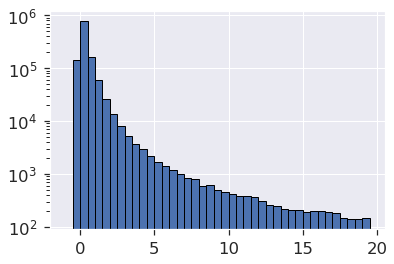

In [28]:
h=plt.hist(df['bdf_T'], bins=np.arange(-1, 20, .5), ec='k')
plt.yscale('log')

In [29]:
print(len(df))
print(len(df[df['bdf_T']<100]))

1230145
1223308


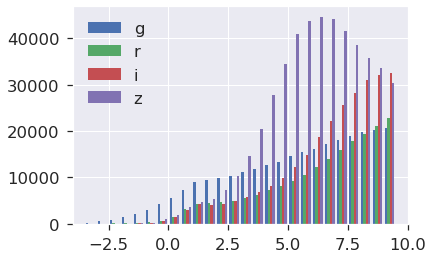

In [24]:
plt.hist(df['bdf_flux_deredden'] / df['bdf_flux_err'], bins=np.arange(-4, 10, .5), label=['g', 'r', 'i', 'z'])
plt.xlim(-4, 10)
plt.legend()
# print(np.max(df['avgbdf']))

In [14]:
# from astropy.io import fits
# with fits.open(det_file) as h:
#     print(h[1].columns)

In [18]:
run = 'y3-merged'
ver = '1.2'

match_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/{}/sof/balrog_matched_catalog_sof_{}_v{}.fits'.format(run, ver, run, ver)
det_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/{}/sof/balrog_detection_catalog_sof_{}_v{}.fits'.format(run, ver, run, ver)

match_cols = ['bal_id', 'meas_cm_mag_deredden',  'true_bdf_mag_deredden', 'true_gap_flux_fwhm4asec', 'meas_gapflux',
              'meas_cm_fracdev', 'true_bdf_fracdev']
det_cols = ['bal_id', 'meas_FLAGS_GOLD_SOF_ONLY', 'flags_foreground', 'flags_footprint', 'flags_badregions', 'match_flag_1.5_asec', 'meas_EXTENDED_CLASS_SOF']
# sof = sc.BalrogMatchedCatalog(match_file, det_file, match_cols=match_cols, match_type='sof_only', vb=True)

print('Loading matched file...')
match = Table(fitsio.read(match_file, columns=match_cols))
print('Loading det file...')
det = Table(fitsio.read(det_file, columns=det_cols))
print('joining...')
sof = join(match, det, keys='bal_id', join_type='inner')
assert len(match) == len(sof)

cuts = np.where(
    (sof['meas_FLAGS_GOLD_SOF_ONLY'] < 2) &
    (sof['flags_foreground'] == 0 ) &
    (sof['flags_footprint'] == 1) &
    (sof['flags_badregions'] < 2) &
    (sof['meas_EXTENDED_CLASS_SOF'] == 0) &
    (sof['match_flag_1.5_asec'] < 2)
)

print('Making cuts...')
sof = sof[cuts]

Loading matched file...
Loading det file...
joining...
Making cuts...


In [ ]:
sof_file = './cats/balrog_sof_gold_phot_scatter.fits' 
print('Writing catalog...')
sof.write(sof_file, overwrite=True)

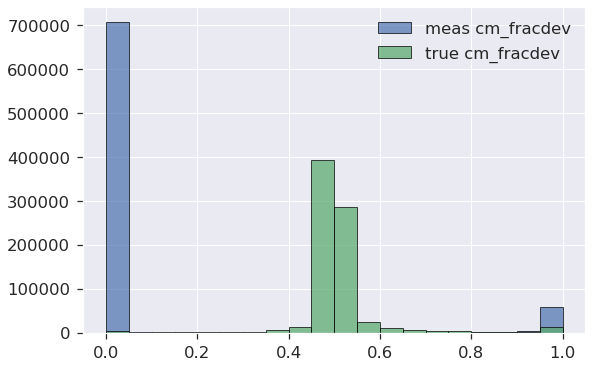

In [25]:
db = 0.05
bins = np.arange(0, 1+db, db)
plt.hist(sof['meas_cm_fracdev'], bins=bins, ec='k', label='meas cm_fracdev', alpha=0.7)
plt.hist(sof['true_bdf_fracdev'], bins=bins, ec='k', label='true cm_fracdev', alpha=0.7)
plt.gcf().set_size_inches(9, 6)
plt.legend()

(array([], dtype=float64), array([0.]), <a list of 0 Patch objects>)

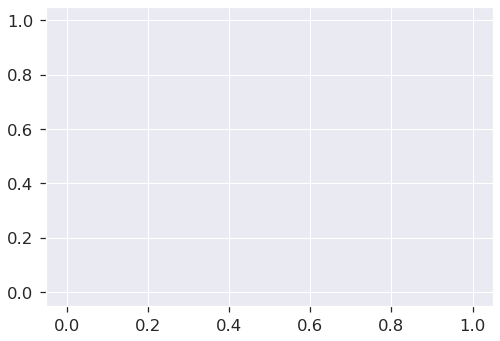

In [23]:
bins

In [3]:
sof_file = './cats/balrog_sof_gold_phot_scatter.fits'
sof = Table.read(sof_file)

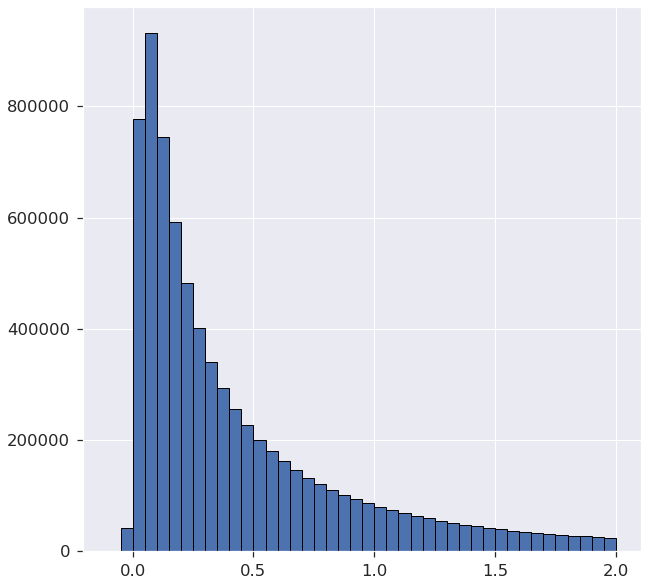

In [11]:
db = .05
plt.hist(sof['meas_cm_T'], ec='k', bins=np.arange(-2*db, 2+db, db))
plt.gcf().set_size_inches(10,10)

/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


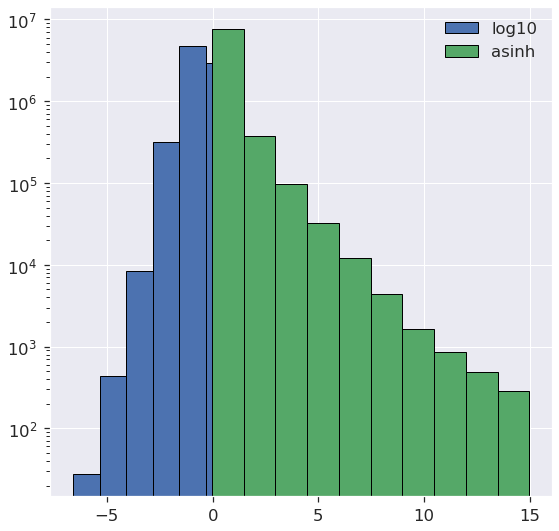

In [17]:
plt.hist(np.log10(sof['meas_cm_T']), label='log10', ec='k')
plt.hist(1.08574*np.arcsinh(sof['meas_cm_T']/2), label='asinh', ec='k')
plt.legend()
plt.yscale('log')
plt.gcf().set_size_inches(9, 9)

/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


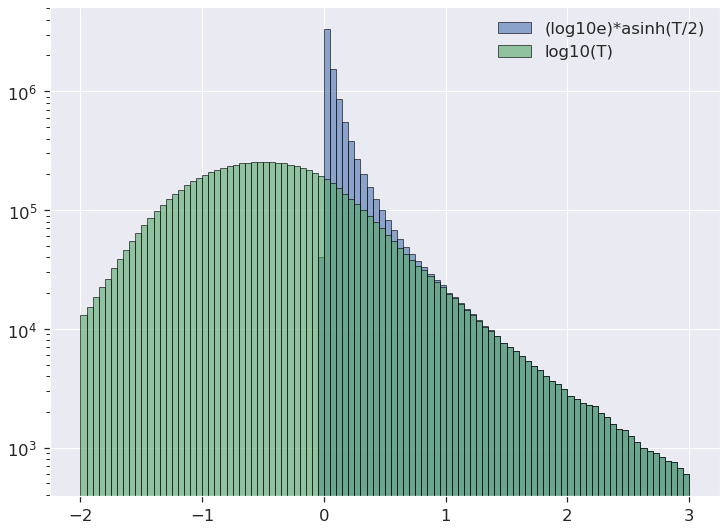

In [33]:
db = 0.05
bins = np.arange(-2, 3+db, db)
plt.hist(1.08574/2.5*np.arcsinh(sof['meas_cm_T']/2), ec='k', bins=bins, alpha=0.6, label='(log10e)*asinh(T/2)')
plt.hist(np.log10(sof['meas_cm_T']), ec='k', bins=bins, alpha=0.6, label='log10(T)')
plt.legend()
plt.yscale('log')
plt.gcf().set_size_inches(12, 9)

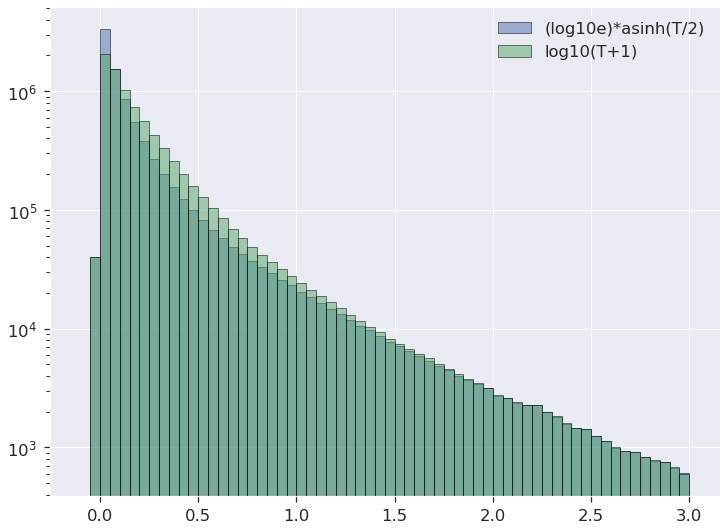

In [38]:
db = 0.05
bins = np.arange(-2*db, 3+db, db)
plt.hist(1.08574/2.5*np.arcsinh(sof['meas_cm_T']/2), ec='k', bins=bins, alpha=0.5, label='(log10e)*asinh(T/2)')
plt.hist(np.log10(sof['meas_cm_T']+1), ec='k', bins=bins, alpha=0.5, label='log10(T+1)')
# plt.hist(np.log10(sof['meas_cm_T']), ec='k', bins=bins, alpha=0.6, label='log10(T)')
plt.legend()
plt.yscale('log')
plt.gcf().set_size_inches(12, 9)

In [39]:
np.log10(1-0.05)

-0.022276394711152253

In [2]:
N = 123456789
N // 500

246913

In [3]:
246913 * 500

123456500

In [4]:
int(N * 0.9)

111111110

In [57]:
N = 1000000
x = np.random.normal(0, 5, N)
y = np.random.normal(0, 5, N)

KeyboardInterrupt: 

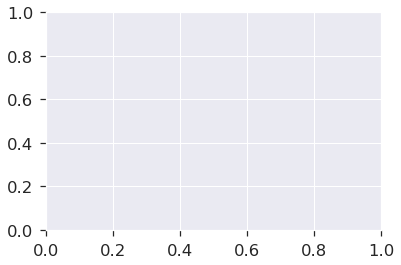

In [43]:
p = sb.kdeplot(x, y, shade=True, shade_lowest=False)

KeyboardInterrupt: 

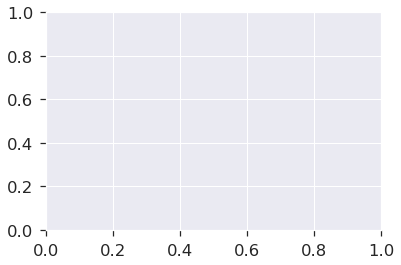

In [50]:
levels = [0, .25, 0.5, 0.75, 1.0, 1.25, 1.5]
p = sb.kdeplot(x, y, shade=True, shade_lowest=False, levels=levels)

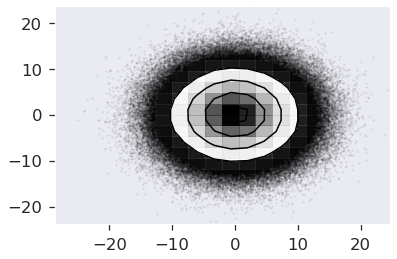

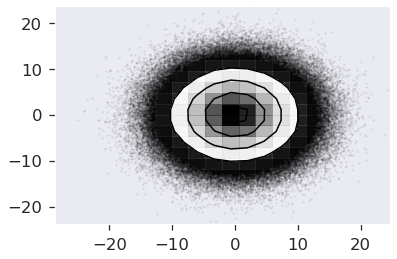

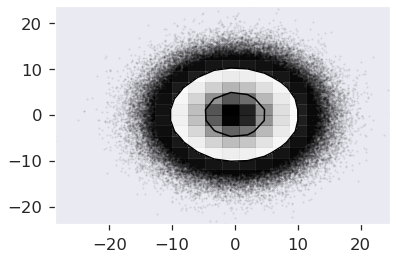

In [70]:
levels = [0.1, 0.5, 0.9]
corner.hist2d(x, y, shade_lowest=False)#, levels=levels)
plt.show()
levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)
corner.hist2d(x, y, shade_lowest=False, levels=levels)
plt.show()
levels = [0.393, .865]
corner.hist2d(x, y, shade_lowest=False, levels=levels)

In [71]:
corner.quantiles(x, y)

AttributeError: module 'corner' has no attribute 'quantiles'

In [73]:
dl=0.5
1.0 - np.exp(-0.5 * np.arange(dl, 2.5+dl, dl) ** 2)

array([0.1175031 , 0.39346934, 0.67534753, 0.86466472, 0.95606307])

In [9]:
b_file = '/project/projectdirs/des/severett/Balrog/run2-gridtest/stacked_catalogs/1.4/sof/balrog_matched_catalog_sof_run2-gridtest_v1.4.fits'

h = fitsio.read_header(b_file, ext=1)
print(h)

# cols = ['meas_cm_mag', 'meas_cm_mag_deredden', 'true_bdf_mag_deredden']
# b = Table(fitsio.read(b_file, columns=cols))


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                 3194 / length of dimension 1
NAXIS2  =              1631119 / length of dimension 2
PCOUNT  =                    0 / number of group parameters
GCOUNT  =                    1 / number of groups
TFIELDS =                   93 / number of table fields
TTYPE1  = 'true_id'            / 
TFORM1  = 'J'                  / 
TTYPE2  = 'true_flags'         / 
TFORM2  = 'J'                  / 
TTYPE3  = 'true_bdf_flags'     / 
TFORM3  = 'J'                  / 
TTYPE4  = 'true_ra'            / 
TFORM4  = 'D'                  / 
TTYPE5  = 'true_dec'           / 
TFORM5  = 'D'                  / 
TTYPE6  = 'true_psf_mag'       / 
TFORM6  = '4D'                 / 
TTYPE7  = 'true_bdf_T'         / 
TFORM7  = 'D'                  / 
TTYPE8  = 'true_bdf_T_err'     / 
TFORM8  = 'D'                  / 
TTYPE9  = 'tru

In [5]:
b

true_bdf_mag_deredden [4],meas_cm_mag [4],meas_cm_mag_deredden [4]
float32,float64,float64
22.424946 .. 21.108538,22.45765140101533 .. 21.16506489641675,22.421051399859 .. 21.151264896576194
23.886084 .. 23.502935,23.712276994176356 .. 24.593636314355464,23.675676993020026 .. 24.579836314514907
25.086351 .. 23.588829,25.115705316132242 .. 23.878339509310727,25.079105314975912 .. 23.86453950947017
24.155743 .. 23.657581,24.25565843469842 .. 24.16962338428062,24.21905843354209 .. 24.155823384440062
24.297508 .. 23.77106,24.44224694975093 .. 23.469509335302327,24.4056469485946 .. 23.45570933546177
24.055511 .. 22.98255,24.063810404806762 .. 22.97918273019241,24.027210403650432 .. 22.965382730351852
24.898176 .. 23.505295,25.113749888133526 .. 23.58218310053554,25.077149886977196 .. 23.568383100694984
24.032648 .. 23.114368,24.013857056130995 .. 22.96553814037015,23.977257054974665 .. 22.951738140529592
23.908813 .. 21.153616,23.92902954538753 .. 21.1459368301606,23.8924295442312 .. 21.132136830320043


In [6]:
b_file = '/project/projectdirs/des/severett/Balrog/run2-gridtest/stacked_catalogs/1.4/sof/balrog_detection_catalog_sof_run2-gridtest_v1.4.fits'
cols = ['bal_id', 'detected']
b = Table(fitsio.read(b_file, columns=cols))

In [7]:
b

bal_id,detected
int64,int64
100000037060,0
100000037061,0
100000037062,0
100000037063,0
100000037064,1
100000037065,1
100000037066,0
100000037067,0
100000037068,0
